# Topic Modeling
---
Topic models are statistical techniques used to identify the most representative "topics" within a collection of documents. These models operate in an unsupervised manner, meaning they do not require labeled data or manual annotations. The key assumption behind topic modeling is that documents about a specific subject tend to share common words. Each document typically consists of multiple topics in varying proportions, but the overall topic distribution remains relatively stable. The final output of a topic model consists of clusters of semantically related words, each representing a different topic.


The most widely used topic modeling technique is Latent Dirichlet Allocation (LDA), which we will focus on in this discussion. However, for completeness, we will also introduce the K-Means clustering approach and Non-Negative Matrix Factorization (NMF), both of which offer alternative ways to discover topics within text data.


## Latent Dirichlet Allocation (LDA)
[Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is a probabilistic generative model that assumes each document is a mixture of topics and that each topic is a distribution over words. It models the way documents are generated, aiming to uncover hidden topic structures within a large corpus of text.

LDA works by iteratively assigning words to topics based on their co-occurrence patterns across documents. The model assumes that words belonging to the same topic are likely to appear together frequently. By iteratively refining these assignments, LDA determines both the topic distribution for each document and the word distribution for each topic.

```shell
1. Initialize topics randomly for each word in each document.
2. Repeat for a set number of iterations or until convergence:
   for each word in each document:
      i. Remove the current topic assignment for the word.
      ii. Compute the probability of assigning the word to each topic 
          based on topic distributions in the document and across all documents.
      iii. Assign the word to a new topic based on these probabilities.
3. Once iterations are complete, extract topic distributions for documents and word distributions for topics.
```

[K-Means](https://en.wikipedia.org/wiki/K-means_clustering) is a partition-based clustering algorithm that can also be used for topic modeling. Unlike LDA, which is a probabilistic approach, K-Means is a distance-based method that groups words (or documents) into *k* clusters based on similarity.

The algorithm works by first randomly initializing *k* cluster centroids, which represent the centers of the topic clusters. Then, it assigns each word (or document) to the nearest centroid based on a similarity measure, typically Euclidean distance. The centroids are updated iteratively until the assignments stabilize, resulting in clearly defined topic clusters.

While K-Means is simpler and computationally efficient, it lacks the probabilistic foundation of LDA and may not capture the nuanced mixture of topics within documents.

```shell
1. Choose the number of clusters (k) and initialize k cluster centroids randomly.
2. Repeat until convergence:
   a. Assign each word to the nearest cluster centroid based on a similarity measure.
   b. Update cluster centroids by computing the mean of all words assigned to each cluster.
3. Stop when cluster assignments no longer change or reach a maximum number of iterations.
```

## Non-Negative Matrix Factorization (NMF)
[Non-Negative Matrix Factorization (NMF)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) is a matrix decomposition technique widely used for topic modeling. Unlike LDA, which is a probabilistic model, or K-Means, which is a clustering approach, NMF is a linear algebra-based method that factorizes a document-word matrix into two lower-dimensional non-negative matrices: one representing topics and the other representing document-topic distributions.

NMF assumes that each document is a combination of a small number of topics and that each topic is composed of a specific set of words with different importance scores. The model optimizes these factorized matrices by minimizing reconstruction error while ensuring that all values remain non-negative, making it highly interpretable.

```shell
1. Construct a document-word matrix where each row represents a document and each column represents a word.
2. Choose the number of topics (k).
3. Initialize two non-negative matrices:
   a. A document-topic matrix (D x k).
   b. A topic-word matrix (k x W).
4. Repeat until convergence:
   a. Update the document-topic and topic-word matrices using an optimization algorithm (e.g., multiplicative updates).
   b. Ensure all matrix values remain non-negative.
5. Extract topic distributions for documents and word distributions for topics.
```

## Import Modules

In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np 

from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [2]:
# Reproducibility
seed = 42

In [3]:
# Directory containing text files
text_dir = r"C:\master\aai_data\text-analysis"  # ".\data"
# text_dir = "./data/"

## Load all texts
Annotations will be ignored and all texts loaded together.

In [4]:
# Read all .txt files from the directory
data_samples = []
for root, dirs, files in os.walk(text_dir):
    if not files:
        continue
    for filename in files:
        if filename.endswith(".txt"):
            with open(os.path.join(root, filename), "r") as file:
                try:
                    data_samples.append(file.read())
                except:
                    print(f"Error reading file: {os.path.join(root, filename)}")

Number of documents:  2225


### Text Sample

In [13]:
print(data_samples[42])

German business confidence slides

German business confidence fell in February knocking hopes of a speedy recovery in Europe's largest economy.

Munich-based research institute Ifo said that its confidence index fell to 95.5 in February from 97.5 in January, its first decline in three months. The study found that the outlook in both the manufacturing and retail sectors had worsened. Observers had been hoping that a more confident business sector would signal that economic activity was picking up.

"We're surprised that the Ifo index has taken such a knock," said DZ bank economist Bernd Weidensteiner. "The main reason is probably that the domestic economy is still weak, particularly in the retail trade." Economy and Labour Minister Wolfgang Clement called the dip in February's Ifo confidence figure "a very mild decline". He said that despite the retreat, the index remained at a relatively high level and that he expected "a modest economic upswing" to continue.

Germany's economy grew 1.

In [14]:
print("Number of documents: ", len(data_samples))
print("Number of words (approximation): ", sum(len(s.replace(r"\n", "").split(" ")) for s in data_samples))

Number of documents:  2225
Number of words (approximation):  844153


### Parameters
Each of these parameters controls an aspect of data processing or model training.
- **`n_features = 2000`**  
  - Defines the number of words (features) to keep in the vocabulary.
  - This limits the dimensionality of the text representation, improving computational efficiency.
  - Words are selected based on frequency thresholds (controlled in the vectorizer settings).

- **`n_components = 10`**  
  - Determines the number of topics to extract from the dataset.
  - The model will attempt to categorize the text into `10` different topics.

- **`n_top_words = 10`**  
  - Specifies the number of top words to display for each topic in the visualizations.
  - Helps interpret the topics by showing the most influential words in each cluster.

- **`init = "nndsvda"`**  
  - Defines the initialization method for NMF models.
  - `"nndsvda"` stands for **Nonnegative Double Singular Value Decomposition with Averages**.
  - This method is useful for achieving better convergence by starting with a structured initialization instead of random values.

- **`max_df = Maximum Document Frequency`**
    - Removes very common words that appear in too many documents.
        - `max_df` = 0.95 Ignores words that appear in more than 95% of documents.

- **`min_df = Minimum Document Frequency`**
    - Removes rare words that appear in very few documents.
        - `min_df` = 0.01 Ignores words that appear in less than 1% of documents.

In [81]:
n_features = 2000
n_components = 10
n_top_words = 10
init = "nndsvda"
max_df = 0.80
min_df = 0.01

### Preprocessing

#### Stop words (naive approach)

In [ ]:
custom_stop_words = set(ENGLISH_STOP_WORDS).union({"said", "one", "would", "like", "also"})
custom_stop_words = list(custom_stop_words)

#### tf-idf

In [94]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=n_features, stop_words=custom_stop_words)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

Extracting tf-idf features for NMF...


#### tf

In [95]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=n_features, stop_words=custom_stop_words)
tf = tf_vectorizer.fit_transform(data_samples)

Extracting tf features for LDA...


### Utils (viz)

In [96]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Fit Models

### NMF

Fitting the NMF model (Frobenius norm)...


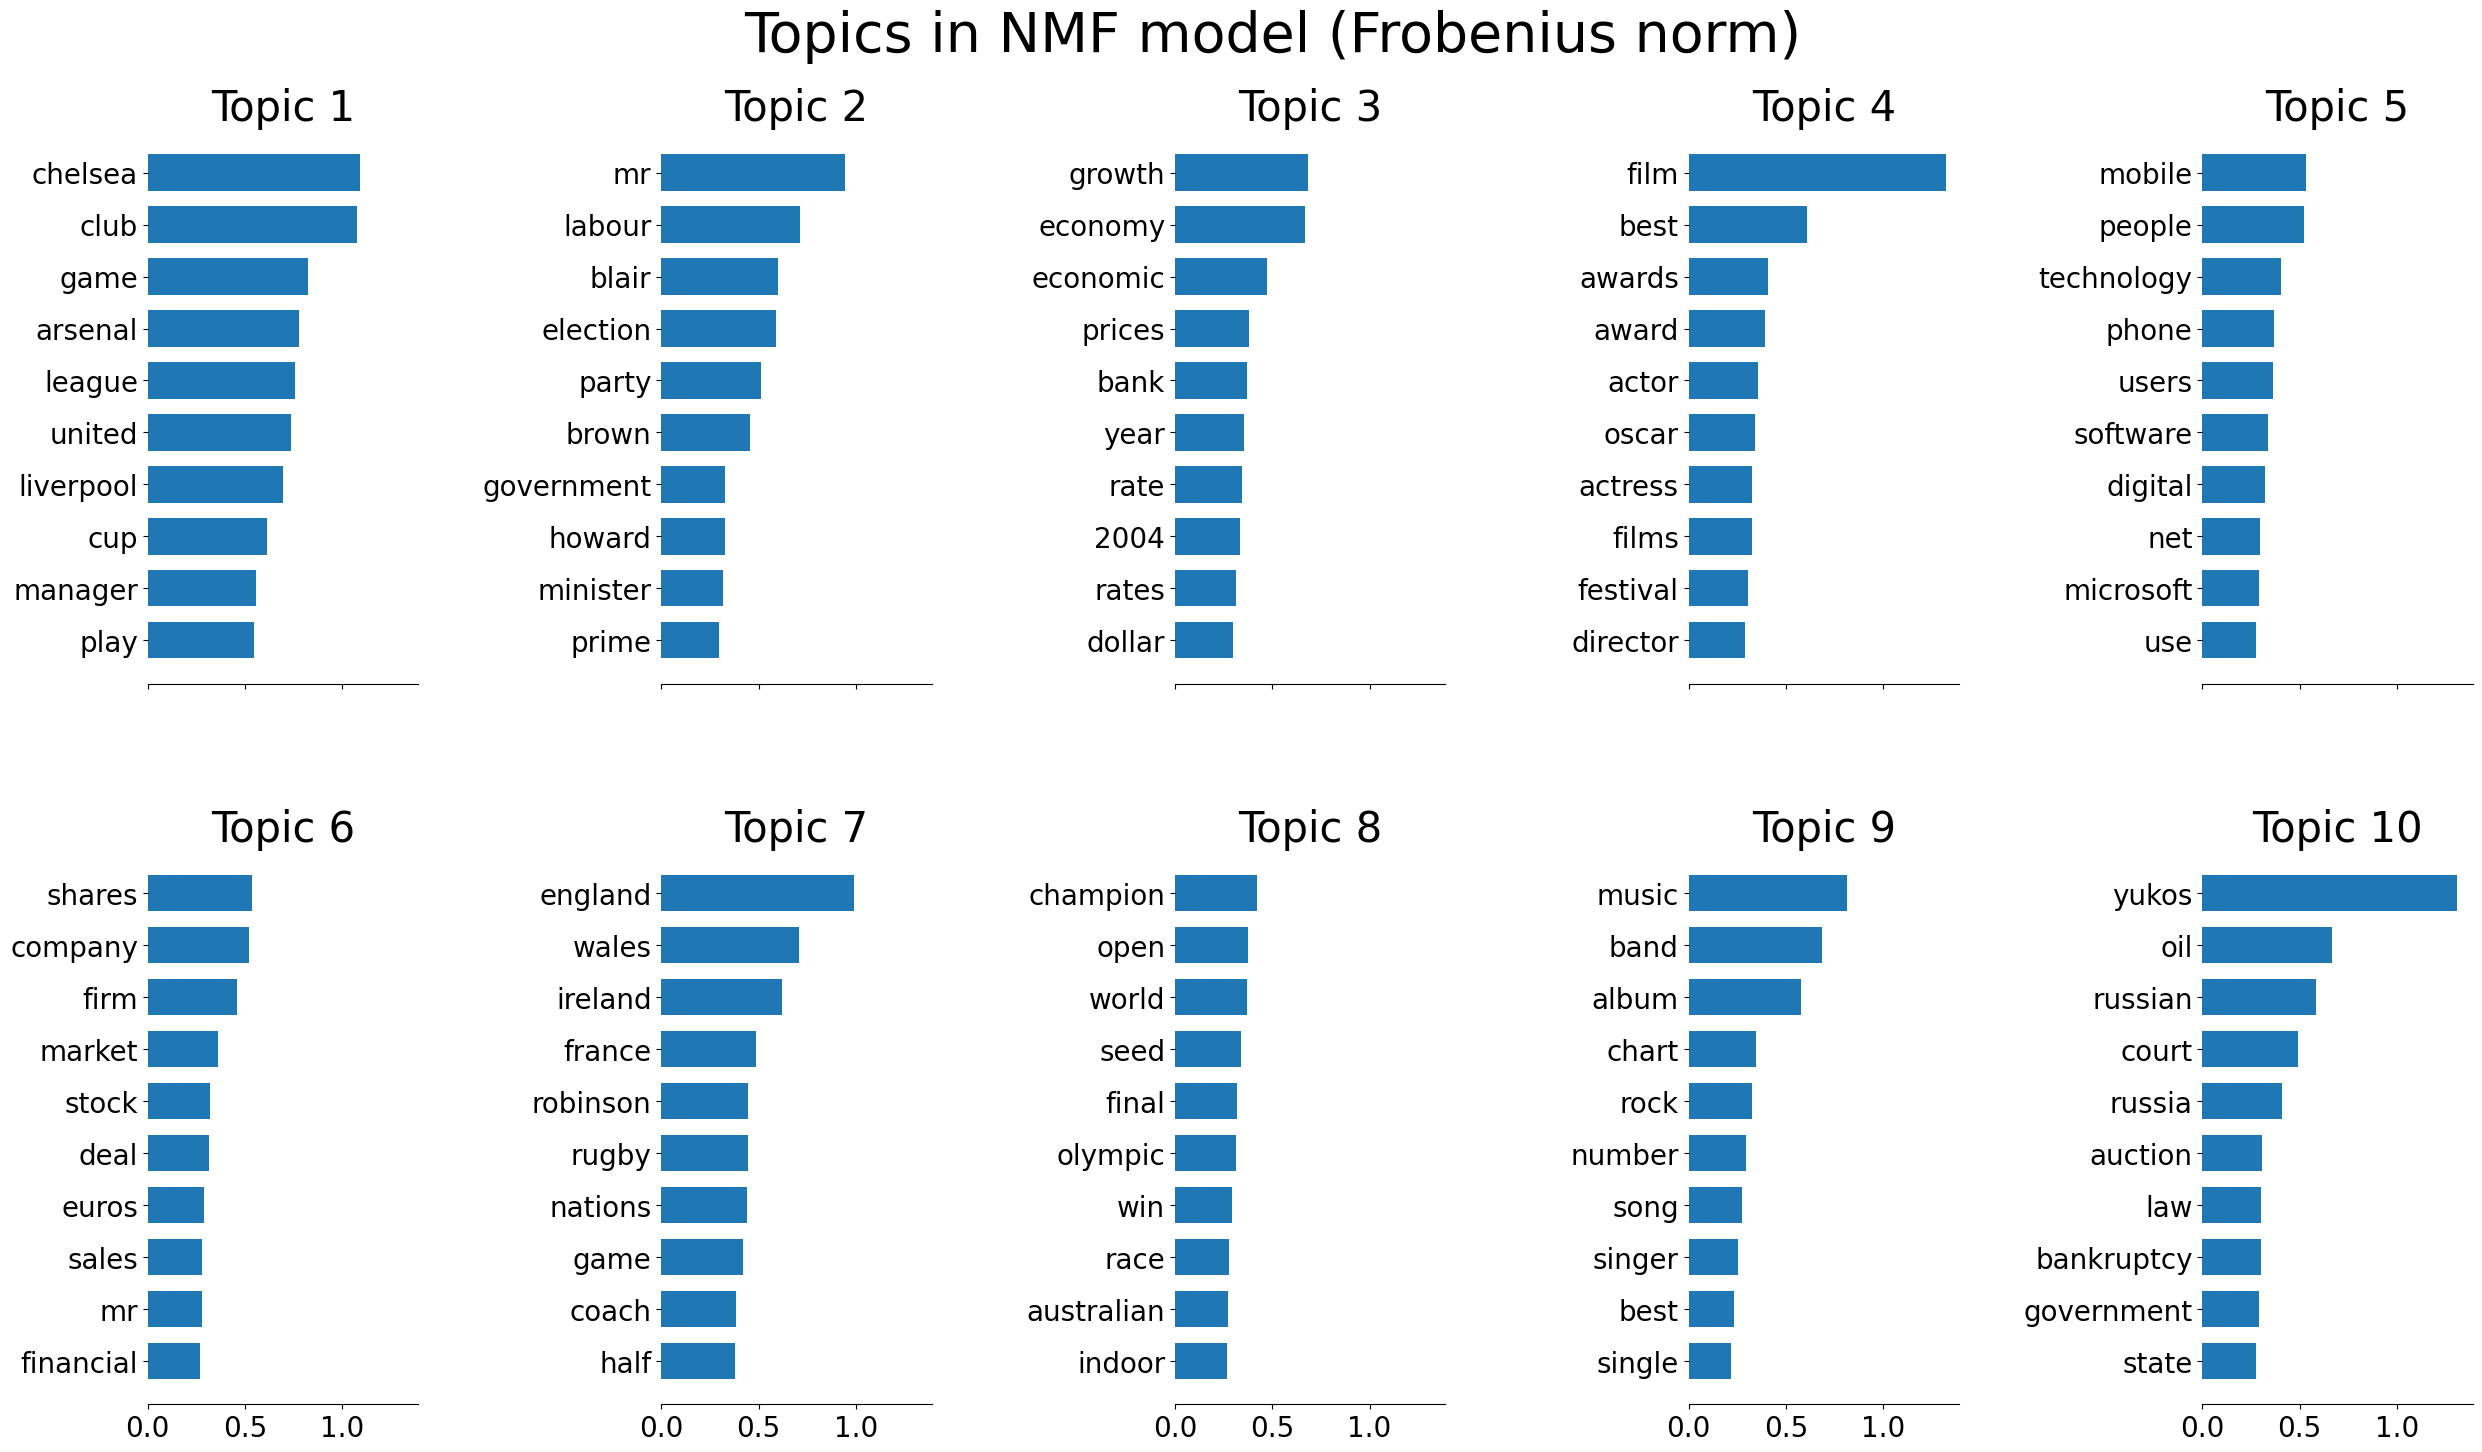

In [97]:
print("Fitting the NMF model (Frobenius norm)...")
nmf = NMF(n_components=n_components, random_state=seed, init=init, beta_loss="frobenius").fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")

Possible topics meaning:

1. **Football**
2. **Politics**
3. **Economy & Finance**
4. **Movies & Entertainment**
5. **Technology & Mobile Industry**
6. **Stock Market & Business** 
7. **Rugby & International Sports** 
8. **Olympic Games** 
9. **Music Industry**
10. **Russian Oil & Law**

### LDA

Fitting LDA model...


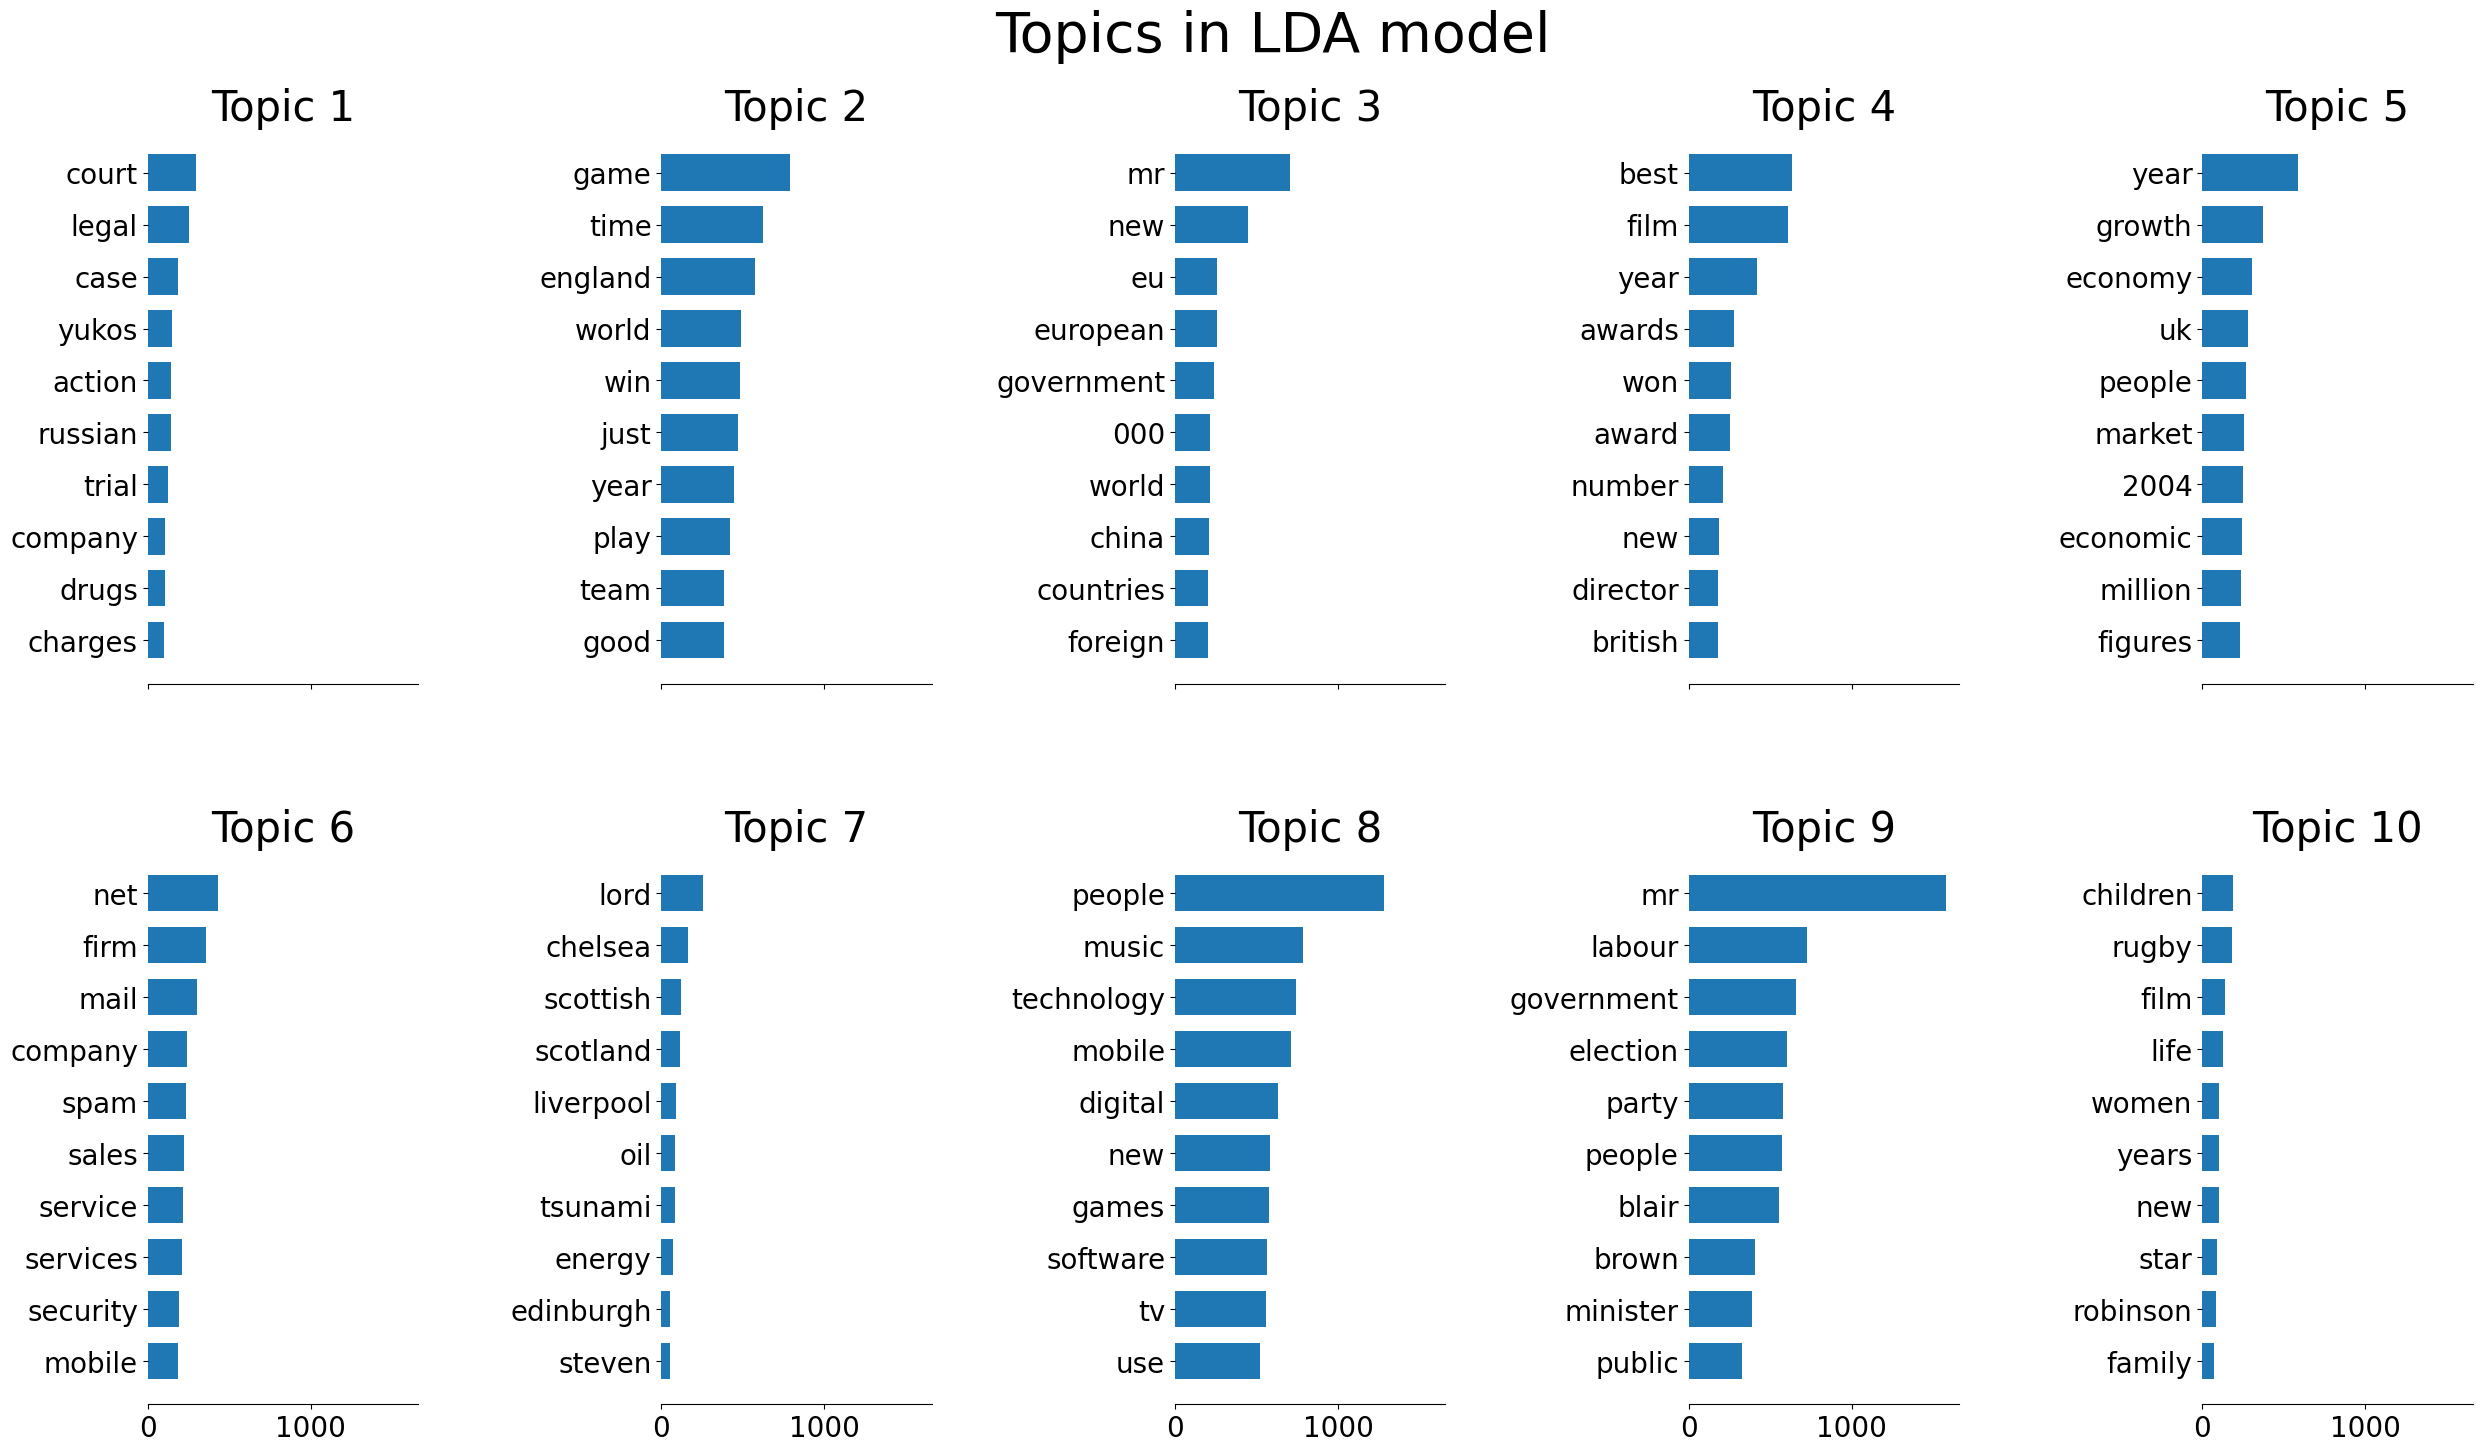

In [98]:
print("Fitting LDA model...")
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method="online", random_state=seed)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

Possible topics meaning:

1. **Russian Oil & Law**
2. **Sports & Competitions**
3. **Politics**
4. **Movies & Entertainment**
5. **Economy & Finance**
6. **Technology & Mobile Industry**
7. **UK & Energy Sector**
8. **Technology & Entertainment**
9. **Politics & Government**
10. **Social & Cultural Issues**

### Summary:
- **Shared topics:** Politics, Economy, Movies, Technology, Sports, and Russian legal affairs appear in both models. However, the way these topics are structured differs, with NMF producing more distinct topic separations, while LDA allows for more blended themes.
- **Distinct topics in NMF:** Football, Tennis, and Stock Market are more specialized in NMF. This is due to NMF's matrix factorization approach, which enforces more distinct, non-overlapping topic assignments, leading to clearer and more industry-specific categories.
- **Distinct topics in LDA:** Social & Cultural Issues and UK & Energy Sector are unique to LDA. This happens because LDA models each document as a mixture of topics, allowing for broader, more generalized groupings where words can appear in multiple topics, leading to themes that combine different aspects of society and economy.
- **Granularity difference:** NMF provides more industry-specific categories, such as separating different sports (Football, Tennis) and financial topics (Stock Market, Economy). LDA, on the other hand, captures broader themes by mixing related terms, which results in topics that are more generalized, such as merging multiple sports into one topic or combining politics with social issues.



## Prediction Examples

### Example 1

In [99]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, HTML

sample_text = data_samples[42]

def colorize_sample_text(sample_text):
    word_tokens = re.findall(r'\b\w+\b', sample_text.lower())
    word_topic_probabilities = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    # Words corresponding to the vectorized text (the features from the vectorizer):
    sample_words = tf_vectorizer.get_feature_names_out()

    # Map each word to its most likely topic
    word_topics = {}
    for idx, word in enumerate(sample_words):
        topic_probs = word_topic_probabilities[:, idx]
        dominant_topic = np.argmax(topic_probs)
        word_topics[word] = dominant_topic

    highlighted_text = []
    cmap = plt.colormaps['Pastel1']
    sample_text_word_topics = {}
    for word in word_tokens:
        if word not in custom_stop_words:
            if word in word_topics:
                topic = word_topics[word]
                sample_text_word_topics[word] = topic
                color = cmap(topic / lda.n_components) 
                highlighted_text.append(f'<span style="background-color: rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)});">{word}</span>')
            else:
                highlighted_text.append(word)
        else:
            highlighted_text.append(word)

    original_text = ' '.join(word_tokens)  
    highlighted_html = ' '.join(highlighted_text)  

    print("Original Text:")
    display(HTML(f"<p>{original_text}</p>"))

    print("\nColored Text:")
    display(HTML(f"<p>{highlighted_html}</p>"))

    return sample_text_word_topics

sample_text_word_topics = colorize_sample_text(sample_text)


Original Text:



Colored Text:


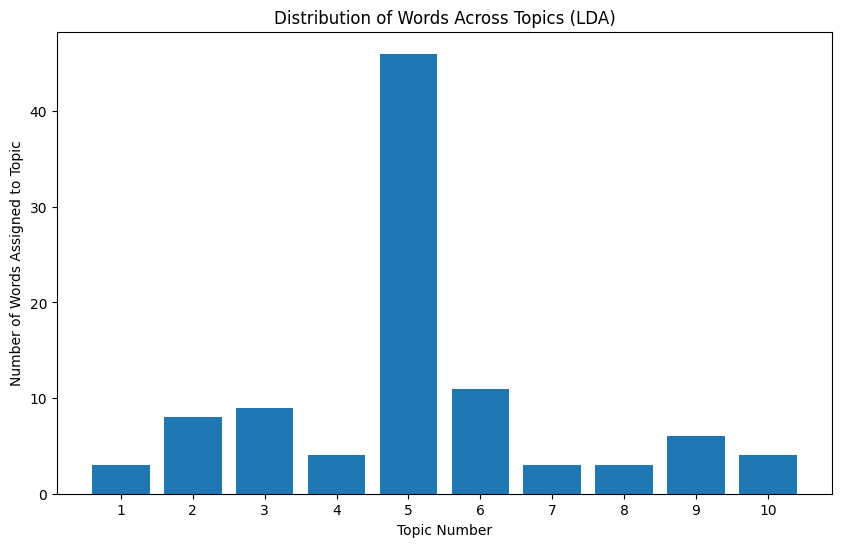

In [100]:
topic_counts = Counter(sample_text_word_topics.values())

plt.figure(figsize=(10, 6))  
plt.bar(topic_counts.keys(), topic_counts.values())
plt.xlabel("Topic Number")
plt.ylabel("Number of Words Assigned to Topic")
plt.title("Distribution of Words Across Topics (LDA)")
plt.xticks(range(lda.n_components), labels=range(1, lda.n_components+1)) 
plt.show()

### Examples 2

Original Text:



Colored Text:


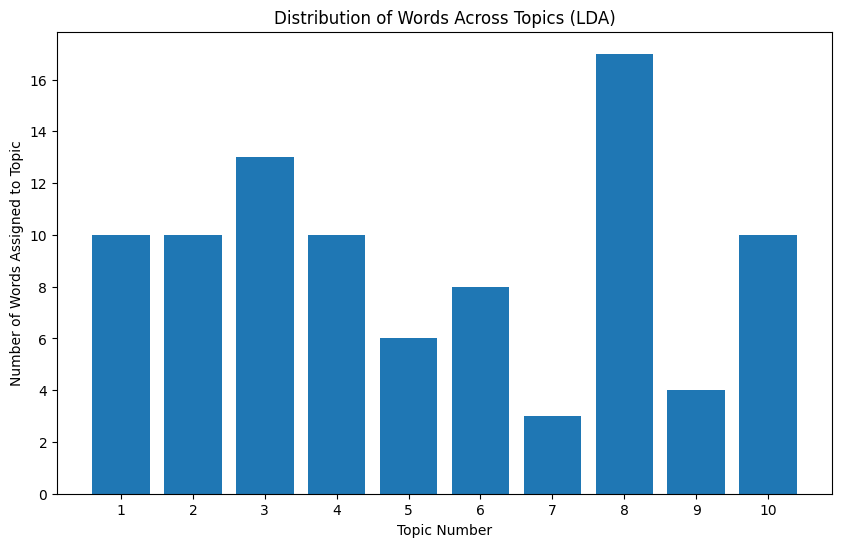

In [101]:
sample_text_word_topics = colorize_sample_text(data_samples[2025])

topic_counts = Counter(sample_text_word_topics.values())

plt.figure(figsize=(10, 6))  
plt.bar(topic_counts.keys(), topic_counts.values())
plt.xlabel("Topic Number")
plt.ylabel("Number of Words Assigned to Topic")
plt.title("Distribution of Words Across Topics (LDA)")
plt.xticks(range(lda.n_components), labels=range(1, lda.n_components+1)) 
plt.show()


## Future Works
- Explore and implement sensitive techniques for determining the optimal number of clusters.
- Enhance preprocessing by incorporating stemming, lemmatization, improved stop word lists, and other relevant methods.
- Explore hyperparameter tuning.